In [1]:
import tensorflow as tf
import numpy as np
from tabulate import tabulate
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def model_info(model, verbose=0):
    layer_info = []
    header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
    data = [[]]
    trainable_layers, non_trainable_layers = 0, 0
    trainable_params, non_trainable_params = 0, 0
    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        input_shape = layer.input_shape[1:]
        output_shape = layer.output_shape[1:]
        trainable = layer.trainable
        layer_type = type(layer).__name__
        data.append([i, layer_type if layer_type != "Functional" else layer.name, input_shape, output_shape, trainable])
        layer_params = np.sum([np.prod(p.shape) for p in layer.weights])
        if trainable:
            trainable_params += layer_params
            trainable_layers += 1
        else:
            non_trainable_params += layer_params
            non_trainable_layers += 1
    print("=========================================================")
    print(f"Total params: {int(trainable_params + non_trainable_params):,}")
    print(f"Trainable params: {int(trainable_params):,}")
    print(f"Non-trainable params: {int(non_trainable_params):,}")
    print(f"Total layers: {len(model.layers):,}")
    print(f"Trainable layers: {trainable_layers:,}")
    print(f"Non-trainable params: {non_trainable_layers:,}")
    print("=========================================================")
    if verbose == 1:
        print(tabulate(data, headers=header, colalign="c", tablefmt="github"))

In [4]:
def get_history_stats(history):
    print(f"Accuracy: {max(history['accuracy']):.{4}f}")
    print(f"Validation accuracy: {max(history['val_accuracy']):.{4}f}")
    print(f"Loss: {min(history['loss']):.{4}f}")
    print(f"Validation loss : {min(history['val_loss']):.{4}f}")    

In [5]:
def plot_hist(history):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.plot(history["accuracy"], label='Training Accuracy')
    plt.plot(history["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.5,1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(history["loss"], label='Training Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [6]:

def plot_total_hist(history1, history2, fine_tunning_epoch):
    initial_epochs = fine_tunning_epoch
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1["accuracy"] + history2["accuracy"], label='Training Accuracy')
    plt.plot(history1["val_accuracy"] + history2["val_accuracy"], label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1["loss"] + history2["loss"], label='Training Loss')
    plt.plot(history1["val_loss"] + history2["val_loss"], label='Validation Loss')
    plt.ylim([0, max(plt.ylim())])
    plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

#### carga de datos

In [7]:
PATH = "/content/drive/MyDrive/Datasets/data"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


#### chekpoints

In [8]:
callbacks_path = "/content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/resnet_models/"
model_name = callbacks_path + "best_model.h5"
fine_model_name = callbacks_path + "best_model_fine.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

fine_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fine_model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

In [9]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                     weights="imagenet", 
                                                     input_shape=IMG_SHAPE)

In [10]:
base_model.trainable = False

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

In [12]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 5e-4

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [15]:
model_info(base_model, verbose=1)

Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
Total layers: 175
Trainable layers: 0
Non-trainable params: 175
|   Number | Name               | Input_shape            | Output_shape   | Trainable   |
|----------|--------------------|------------------------|----------------|-------------|
|          |                    |                        |                |             |
| 0        | InputLayer         | []                     | []             | False       |
| 1        | ZeroPadding2D      | (224, 224, 3)          | (230, 230, 3)  | False       |
| 2        | Conv2D             | (230, 230, 3)          | (112, 112, 64) | False       |
| 3        | BatchNormalization | (112, 112, 64)         | (112, 112, 64) | False       |
| 4        | Activation         | (112, 112, 64)         | (112, 112, 64) | False       |
| 5        | ZeroPadding2D      | (112, 112, 64)         | (114, 114, 64) | False       |
| 6        | MaxPooling2D       | (114, 114, 64)

In [16]:
model_info(model, verbose=1)

Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
Total layers: 8
Trainable layers: 7
Non-trainable params: 1
|   Number | Name                   | Input_shape   | Output_shape   | Trainable   |
|----------|------------------------|---------------|----------------|-------------|
|          |                        |               |                |             |
| 0        | InputLayer             | []            | []             | True        |
| 1        | Sequential             | (224, 224, 3) | (224, 224, 3)  | True        |
| 2        | SlicingOpLambda        | (224, 224, 3) | (224, 224, 3)  | True        |
| 3        | TFOpLambda             | (224, 224, 3) | (224, 224, 3)  | True        |
| 4        | resnet50               | (224, 224, 3) | (7, 7, 2048)   | False       |
| 5        | GlobalAveragePooling2D | (7, 7, 2048)  | (2048,)        | True        |
| 6        | Dropout                | (2048,)       | (2048,)        | True        |
| 7     

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [18]:
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset, 
    callbacks=[model_checkpoint]
)

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.7270
Epoch 1: val_accuracy improved from -inf to 0.81818, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/resnet_models/best_model.h5
83/83 [==============================] - 39s 285ms/step - loss: 0.5433 - accuracy: 0.7270 - val_loss: 0.4343 - val_accuracy: 0.8182
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8184
Epoch 2: val_accuracy improved from 0.81818 to 0.84242, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/resnet_models/best_model.h5
83/83 [==============================] - 13s 151ms/step - loss: 0.3941 - accuracy: 0.8184 - val_loss: 0.3673 - val_accuracy: 0.8424
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8347
Epoch 3: val_accuracy improved from 0.84242 to 0.86515, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes

In [19]:
print(history.history)

{'loss': [0.5432854294776917, 0.3940601348876953, 0.3687192499637604, 0.3407508432865143, 0.32953113317489624, 0.3334886133670807, 0.30432143807411194, 0.29417717456817627, 0.29329052567481995, 0.28650039434432983, 0.28882694244384766, 0.2916043698787689, 0.2766847610473633, 0.2749682068824768, 0.2771528959274292, 0.27257782220840454, 0.2587204575538635, 0.2730833888053894, 0.2610197365283966, 0.26565021276474], 'accuracy': [0.7269624471664429, 0.8183541893959045, 0.8346605896949768, 0.8437618613243103, 0.850208580493927, 0.850208580493927, 0.8653773069381714, 0.8695487380027771, 0.8684110641479492, 0.875236988067627, 0.8695487380027771, 0.8680318593978882, 0.875236988067627, 0.8756162524223328, 0.8691695332527161, 0.8756162524223328, 0.8854759335517883, 0.8740993738174438, 0.8847174644470215, 0.8824421763420105], 'val_loss': [0.4342767894268036, 0.36729785799980164, 0.3241215646266937, 0.31875964999198914, 0.349294513463974, 0.32447385787963867, 0.31498947739601135, 0.3053377568721771

#### ajuste fino

In [20]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [36]:
layers_unfrize = 15

In [37]:
base_model.trainable = True

In [38]:
for i, layer in enumerate(base_model.layers[:-layers_unfrize]):
    layer.trainable = False
for i, layer in enumerate(base_model.layers[-layers_unfrize:]):
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            layer.trainable = False

In [39]:
model_info(base_model, verbose=1)

Total params: 23,587,712
Trainable params: 5,510,144
Non-trainable params: 18,077,568
Total layers: 175
Trainable layers: 11
Non-trainable params: 164
|   Number | Name               | Input_shape            | Output_shape   | Trainable   |
|----------|--------------------|------------------------|----------------|-------------|
|          |                    |                        |                |             |
| 0        | InputLayer         | []                     | []             | False       |
| 1        | ZeroPadding2D      | (224, 224, 3)          | (230, 230, 3)  | False       |
| 2        | Conv2D             | (230, 230, 3)          | (112, 112, 64) | False       |
| 3        | BatchNormalization | (112, 112, 64)         | (112, 112, 64) | False       |
| 4        | Activation         | (112, 112, 64)         | (112, 112, 64) | False       |
| 5        | ZeroPadding2D      | (112, 112, 64)         | (114, 114, 64) | False       |
| 6        | MaxPooling2D       | (114,

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [43]:
fine_epochs = 20
total_epochs = epochs + fine_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[fine_model_checkpoint])

Epoch 20/40
83/83 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9898
Epoch 20: val_accuracy did not improve from 0.90000
83/83 [==============================] - 19s 170ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.6244 - val_accuracy: 0.8894
Epoch 21/40
83/83 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9917
Epoch 21: val_accuracy did not improve from 0.90000
83/83 [==============================] - 14s 161ms/step - loss: 0.0227 - accuracy: 0.9917 - val_loss: 0.7312 - val_accuracy: 0.8773
Epoch 22/40
83/83 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9860
Epoch 22: val_accuracy did not improve from 0.90000
83/83 [==============================] - 14s 160ms/step - loss: 0.0311 - accuracy: 0.9860 - val_loss: 0.7398 - val_accuracy: 0.8818
Epoch 23/40
83/83 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9894
Epoch 23: val_accuracy improved from 0.90000 to 0.90455, saving mode

In [44]:
get_history_stats(history.history)

Accuracy: 0.8855
Validation accuracy: 0.8833
Loss: 0.2587
Validation loss : 0.2797


In [45]:
get_history_stats(history_fine.history)

Accuracy: 0.9989
Validation accuracy: 0.9045
Loss: 0.0054
Validation loss : 0.5720


In [46]:
print(history.history)

{'loss': [0.5432854294776917, 0.3940601348876953, 0.3687192499637604, 0.3407508432865143, 0.32953113317489624, 0.3334886133670807, 0.30432143807411194, 0.29417717456817627, 0.29329052567481995, 0.28650039434432983, 0.28882694244384766, 0.2916043698787689, 0.2766847610473633, 0.2749682068824768, 0.2771528959274292, 0.27257782220840454, 0.2587204575538635, 0.2730833888053894, 0.2610197365283966, 0.26565021276474], 'accuracy': [0.7269624471664429, 0.8183541893959045, 0.8346605896949768, 0.8437618613243103, 0.850208580493927, 0.850208580493927, 0.8653773069381714, 0.8695487380027771, 0.8684110641479492, 0.875236988067627, 0.8695487380027771, 0.8680318593978882, 0.875236988067627, 0.8756162524223328, 0.8691695332527161, 0.8756162524223328, 0.8854759335517883, 0.8740993738174438, 0.8847174644470215, 0.8824421763420105], 'val_loss': [0.4342767894268036, 0.36729785799980164, 0.3241215646266937, 0.31875964999198914, 0.349294513463974, 0.32447385787963867, 0.31498947739601135, 0.3053377568721771

In [47]:
print(history_fine.history)

{'loss': [0.03306056186556816, 0.022733667865395546, 0.031079581007361412, 0.02718786709010601, 0.017345212399959564, 0.023276761174201965, 0.014657224528491497, 0.018230069428682327, 0.018332911655306816, 0.00796489231288433, 0.0053955321200191975, 0.007140886038541794, 0.021104151383042336, 0.017449479550123215, 0.013530919328331947, 0.010366212576627731, 0.011366753838956356, 0.011095231398940086, 0.011291097849607468, 0.01175696961581707, 0.01574777439236641], 'accuracy': [0.9897611141204834, 0.9916571974754333, 0.9859688878059387, 0.9893818497657776, 0.9950701594352722, 0.9920364022254944, 0.9962078332901001, 0.9962078332901001, 0.9939324855804443, 0.9973454475402832, 0.9988623261451721, 0.997724711894989, 0.9927948713302612, 0.9950701594352722, 0.9958285689353943, 0.9954493641853333, 0.9958285689353943, 0.9969662427902222, 0.9962078332901001, 0.9958285689353943, 0.9946909546852112], 'val_loss': [0.6244130730628967, 0.731184184551239, 0.7398054003715515, 0.6162004470825195, 0.8093

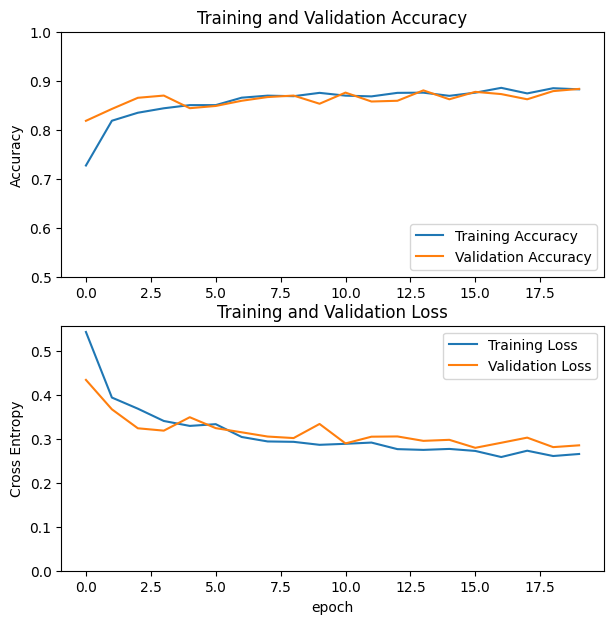

In [48]:
plot_hist(history.history)

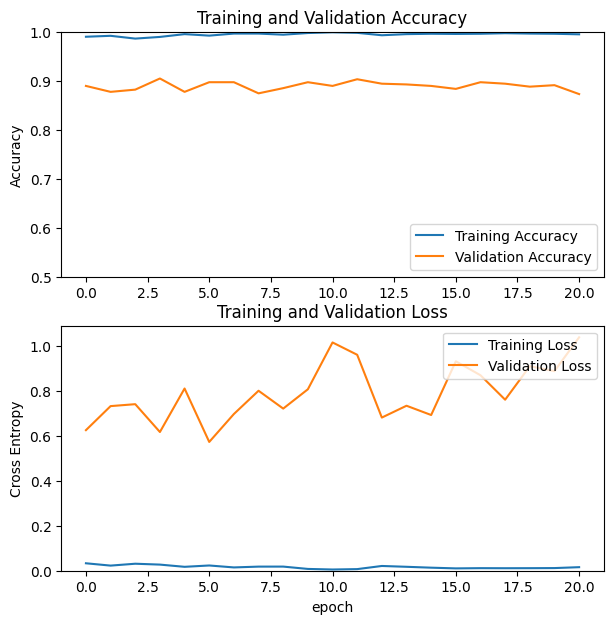

In [49]:
plot_hist(history_fine.history)

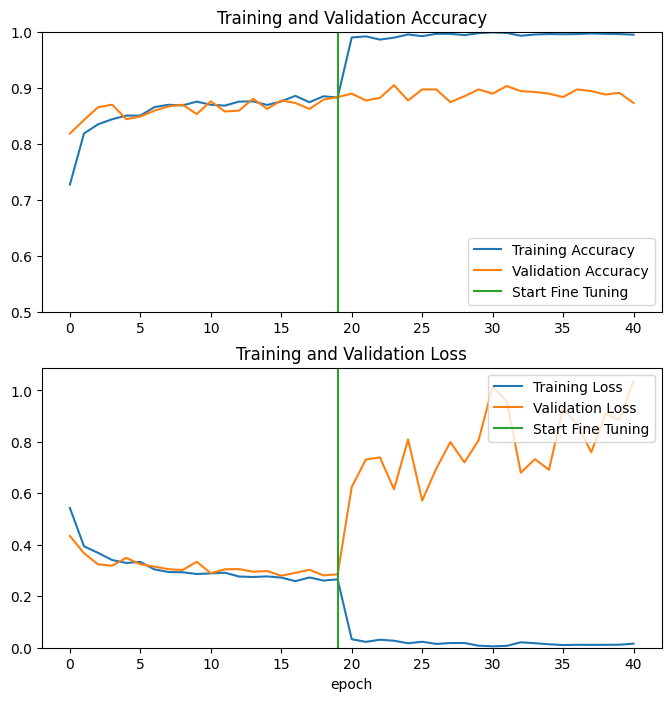

In [50]:
plot_total_hist(history.history, history_fine.history, fine_epochs)